# Улучшение работы сервиса по аренде самокатов GoFast

# Описание проекта 

Имеются данные сервиса аренды самокатов GoFast.

Цель проекта - исследовать данные и на основе полученных результатов предложить стратегии по повышению эффективности и росту прибыли бизнеса.

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
- без подписки
    - абонентская плата отсутствует;
    - стоимость одной минуты поездки — 8 рублей;
    - стоимость старта (начала поездки) — 50 рублей;
- с подпиской Ultra
    - абонентская плата — 199 рублей в месяц;
    - стоимость одной минуты поездки — 6 рублей;
    - стоимость старта — бесплатно.

План проекта: 
- [Общая информация](#1)
- [Предобработка данных](#2)
- [Исследовательский анализ данных](#3)
- [Объединение данных](#4)
- [Подсчёт выручки](#5)
- [Проверка гипотез](#6)
- [Дополнительное исслеодование](#7)
- [Вывод](#8)

# Описание данных

# Общая информация
<a id='1'></a>

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
try:
    users = pd.read_csv('/datasets/users_go.csv')
    rides = pd.read_csv('/datasets/rides_go.csv')
    subscr = pd.read_csv('/datasets/subscriptions_go.csv')
except: 
    users = pd.read_csv('./users_go.csv')
    rides = pd.read_csv('./rides_go.csv')
    subscr = pd.read_csv('./subscriptions_go.csv')



In [3]:
print(users.info())
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
None


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


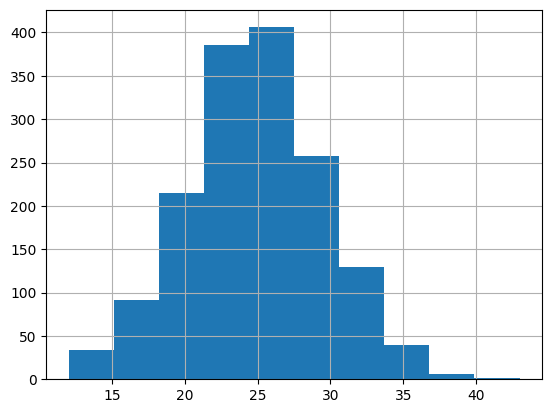

In [4]:
users['age'].hist();

Первичный обзор данных таблицы users:
- количество заполненных ячеек одинаково в каждом столбце и совпадает с общим количеством строк, значит, пропусков нет;
- наличие дубликатов проверим ниже;
- тип данных в каждом столбце корректный;
- в столбце возраста есть редкие (старше 37 лет) и аномальные (младше 18 лет) значения.

In [5]:
print(rides.info())
rides.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB
None


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


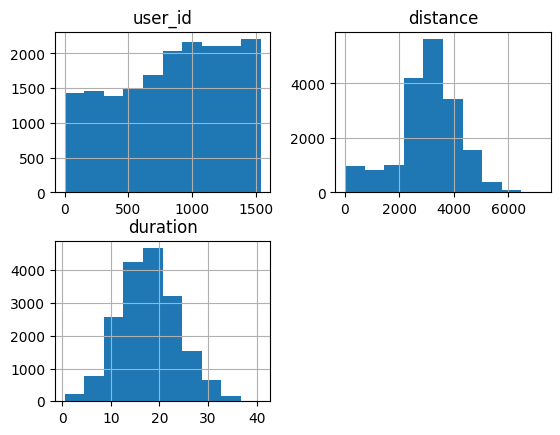

In [6]:
rides.hist();

Первичный обзор данных таблицы rides:
- количество заполненных ячеек одинаково в каждом столбце и совпадает с общим количеством строк, значит, пропусков нет;
- наличие дубликатов проверим ниже;
- тип данных в столбце 'date' object. Ниже приведем к типу date. В остальных столбцах тип данных корректный;
- в столбце расстояния есть аномальные (близкие к 0) и редкие (больше 6000м) значения;
- в столбце длительности поездки также есть аномальные (близкие к 0) и редкие (больше 35 минут) значения.

In [7]:
subscr

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


# Предобработка данных
<a id='2'></a>

Вычислим долю пропусков и явных дубликатов в таблицах users и rides; удалим дубликаты, если они были:

In [8]:
users.isna().mean().sort_values()*100

user_id              0.0
name                 0.0
age                  0.0
city                 0.0
subscription_type    0.0
dtype: float64

In [9]:
users.duplicated().mean()*100

1.9808306709265175

In [10]:
users = users.drop_duplicates()

In [11]:
rides.isna().mean().sort_values()*100

user_id     0.0
distance    0.0
duration    0.0
date        0.0
dtype: float64

In [12]:
rides.duplicated().mean()*100

0.0

Пропусков в данных не обнаружено. Явные дубликаты удалены: для таблицы пользователей дубликаты составили 2%, а в таблице поездок дубликатов не было.

---

Проверим наличие неявных дубликатов в столбце 'city' таблицы users:

In [13]:
users['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

Неявных дубликатов не обнаружено.

---

Приведем столбец date к типу даты pandas и создадим новый столбец с номером месяца на основе столбца date:

In [14]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')
rides['month'] = pd.DatetimeIndex(rides['date']).month

---

Переведем данные столбца distance в км. Округлим до 1 знака после запятой данные в столбцах distance и duration:

In [15]:
rides['distance']= round(rides['distance']/1000,1)
rides['duration'] = round(rides['duration'],1)
rides.head()

,user_id,distance,duration,date,month
0,1,4.4,25.6,2021-01-01,1
1,1,2.6,15.8,2021-01-18,1
2,1,0.8,6.2,2021-04-20,4
3,1,2.7,18.5,2021-08-11,8
4,1,4.0,26.3,2021-08-28,8


---

Проверим, за какой период предоставлены данные о поездках:

In [16]:
rides['date'].describe(datetime_is_numeric=True)

count                            18068
mean     2021-06-30 19:47:21.266327296
min                2021-01-01 00:00:00
25%                2021-04-02 00:00:00
50%                2021-06-30 00:00:00
75%                2021-09-28 00:00:00
max                2021-12-30 00:00:00
Name: date, dtype: object

Данные предосталвены за 2021 год, поэтому дальнейшее разбиение на месяцы корректно.

---

На этапе предобработки данных: 
- выявлено, что данные предоставлены за 2021 год (с 1 января по 30 декабря)
- удалены явные дубликаты в таблице users;
- проверены данные на наличие пропусков и неявных дубликатов (таких не обнаружено);
- столбец 'date' приведен к типу date;
- столбец 'distance' переведен в км и округлен до 1 знака после запятой;
- столбец 'duration' округлен до 1 знака после запятой.

# Исследовательский анализ данных
<a id='3'></a>

Создадим копии исходных датафреймов для изменения данных:

In [17]:
good_users = users
good_rides = rides

## Города

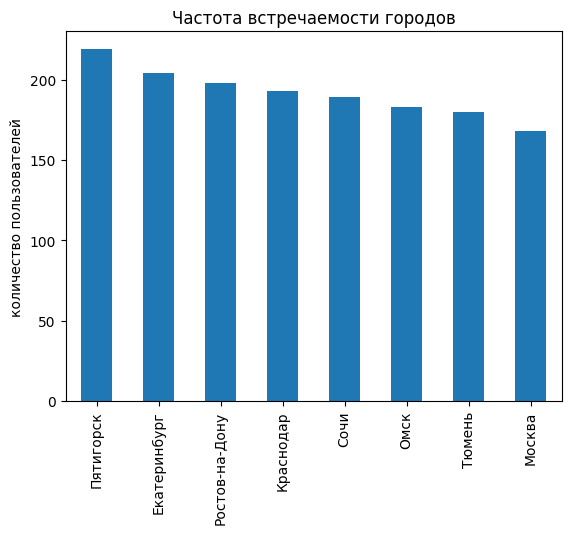

In [18]:
good_users['city'].value_counts().plot(kind = 'bar', title = 'Частота встречаемости городов', ylabel = 'количество пользователей');

Таблица с числовыми значениями частотности городов:

In [19]:
good_users['city'].value_counts()

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

На столбчатой диаграмме выше видно, что все 8 городов встречаются почти одинаковое количестов раз, однако самый популярный город - Пятигорск (около 220 пользоватлей), а наименее популряный - Москва ( около 175 пользователей) 

## Пользователи с подпиской и без

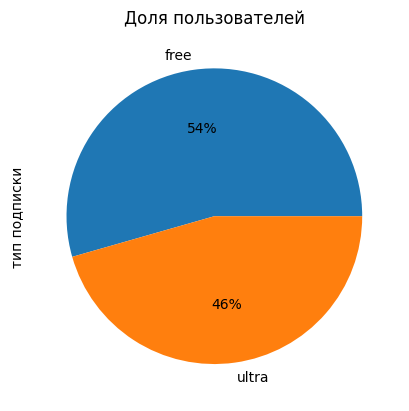

In [20]:
good_users['subscription_type'].value_counts().plot(kind = 'pie', ylabel='тип подписки', title = 'Доля пользователей', autopct='%1.0f%%');

Круговая диаграмма показала, что пользовталей без подписки больше половины.

## Возраст пользователей 

In [21]:
good_users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

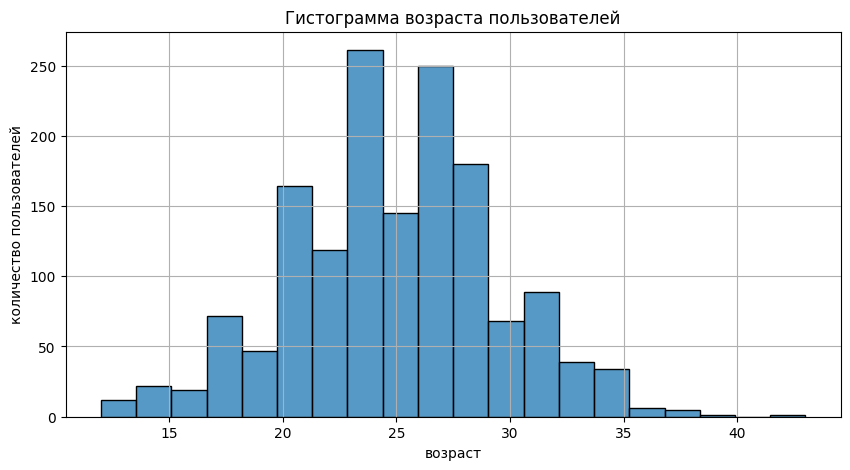

In [22]:
plt.figure(figsize=(10, 5))
sns.histplot(good_users['age'], bins=20)
plt.grid(True)
plt.title('Гистограмма возраста пользователей')
plt.xlabel('возраст')
plt.ylabel('количество пользователей')
plt.show()

В основном, сервисом пользуются люди от 22 до 28 лет. 

Арендовать самокаты могут только люди старше 18 лет, однако, в данных присутсвует информация о пользователях младше 18. Скорее всего, произошла ошибка при выгрузке данных и стоит обратиться к разработчикам. Удалять такие данные не будем, потому что оплата за эти данные была получена, то они представляют собой реальные наблюдения, а не аномалии или выбросы. Удалять такие наблюдения может привести к потере важной информации и возможным искажениям результатов и выводов на основе анализа данных.

## Расстояние, которое пользователь преодолел за одну поездку

In [23]:
good_rides['distance'].describe()

count    18068.000000
mean         3.070716
std          1.117278
min          0.000000
25%          2.500000
50%          3.100000
75%          3.800000
max          7.200000
Name: distance, dtype: float64

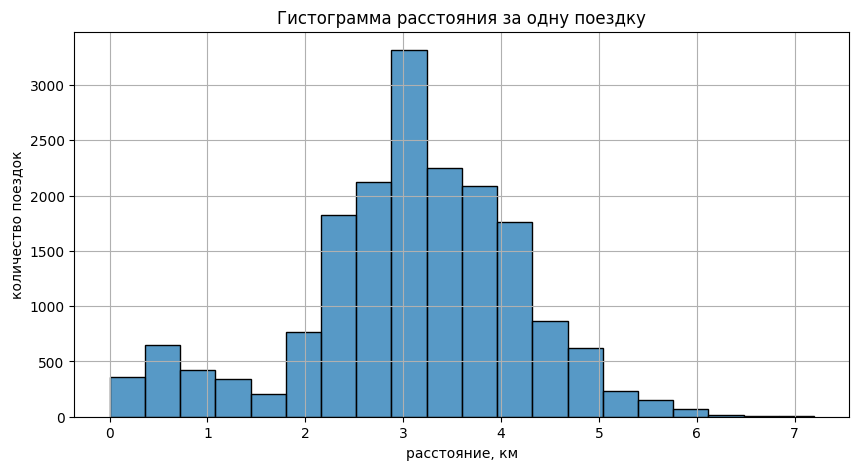

In [24]:
plt.figure(figsize=(10, 5))
sns.histplot(good_rides['distance'], bins=20)
plt.grid(True)
plt.title('Гистограмма расстояния за одну поездку')
plt.xlabel('расстояние, км')
plt.ylabel('количество поездок')
plt.show()

Расстояние, которое пользователь проехал за одну поездку, в среднем составляет от 2.5 до 3.8 км.

Гистограмма выше обнаружила значения, меньшие 1 км (в частности, 0 км). Скорее всего, пользователь либо арендовал по ошибке самокат (например, не в той точке), либо сервис дал сбой. Однако, если оплата за эти данные была получена, то они представляют собой реальные наблюдения, а не аномалии или выбросы. Удалять такие наблюдения может привести к потере важной информации и возможным искажениям результатов и выводов на основе анализа данных.

## Продолжительность поездок

In [25]:
good_rides['duration'].describe()

count    18068.000000
mean        17.804920
std          6.091365
min          0.500000
25%         13.600000
50%         17.700000
75%         21.700000
max         40.800000
Name: duration, dtype: float64

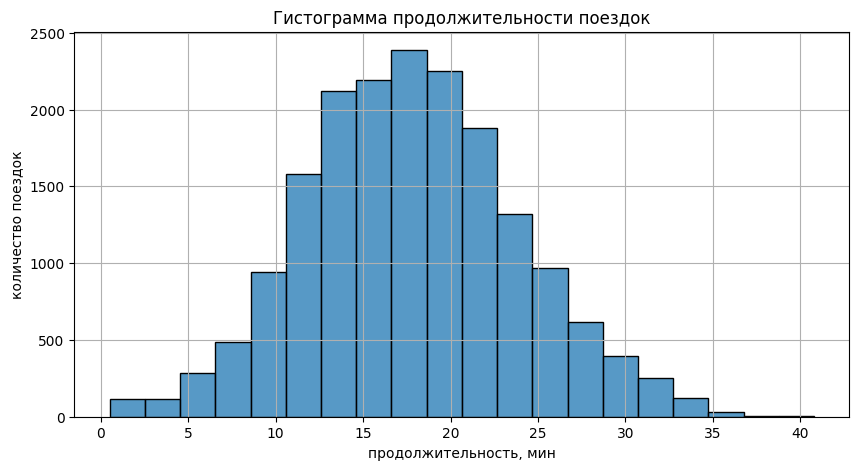

In [26]:
plt.figure(figsize=(10, 5))
sns.histplot(good_rides['duration'], bins=20)
plt.grid(True)
plt.title('Гистограмма продолжительности поездок')
plt.xlabel('продолжительность, мин')
plt.ylabel('количество поездок')
plt.show()

Обычно длительность поездки составляет от 14 до 22 минут.

# Объединение данных
<a id='4'></a>

Объединим данные в одну таблицу по столбцу 'user_id':

In [27]:
data = good_users.merge(good_rides, on = 'user_id')

In [28]:
data.shape[0]/good_rides.shape[0]

1.0

В методе merge по умолчанию стоит параметр объединения 'inner'. Таким образом, в объединенном датафрейме не могло появиться новых пропусков (с учетом того, что на этапе предобработки данных было выявлено, что пропусков в исходных таблицах нет). Более того, размерность объединенной таблицы совпала с размерностью таблицы good_rides.

Модель использования сервиса у пользователей с подпиской и без различается, поэтому создадим еще два датафрейма, которые будут хранить информацию о пользователях и поездках с подпиской и без.

In [29]:
data_ultra = data[data['subscription_type'] == 'ultra']

In [30]:
data_free =  data[data['subscription_type'] == 'free']

Изучим эти два датафрейма по отдельности: 

In [31]:
data_ultra.shape[0]/data.shape[0]

0.3597520478193491

In [32]:
data_ultra.describe()

,user_id,age,distance,duration,month
count,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000
mean,348.725385,24.892615,3.115662,18.541692,6.422308
std,201.099339,4.757208,0.837214,5.572126,3.414616
min,1.000000,12.000000,0.200000,3.800000,1.000000
25%,175.000000,22.000000,2.800000,14.500000,4.000000
50%,351.000000,25.000000,3.100000,18.200000,6.000000
75%,525.000000,28.000000,3.600000,21.900000,9.000000
max,699.000000,38.000000,5.700000,40.800000,12.000000


In [33]:
data_free.describe()

,user_id,age,distance,duration,month
count,11568.000000,11568.000000,11568.000000,11568.000000,11568.000000
mean,1120.527230,24.893326,3.045462,17.390932,6.522994
std,241.165628,4.481100,1.246675,6.327256,3.449770
min,700.000000,12.000000,0.000000,0.500000,1.000000
25%,915.000000,22.000000,2.400000,13.000000,4.000000
50%,1123.000000,25.000000,3.100000,17.300000,7.000000
75%,1328.000000,28.000000,3.900000,21.600000,9.000000
max,1534.000000,43.000000,7.200000,34.900000,12.000000


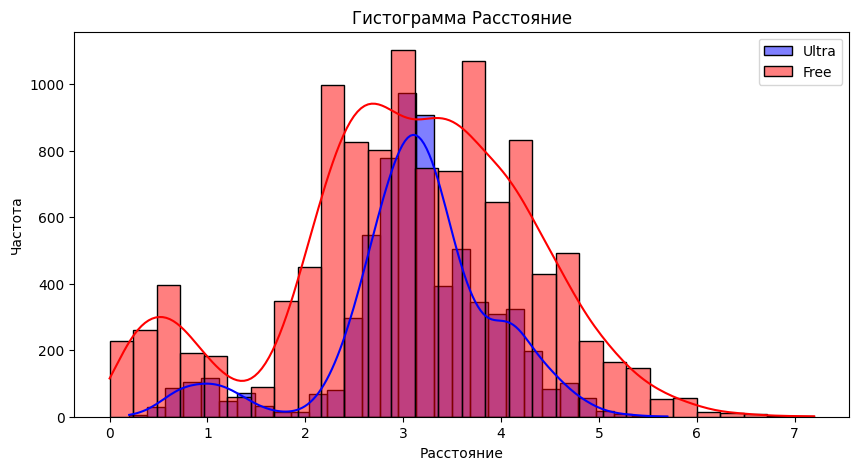

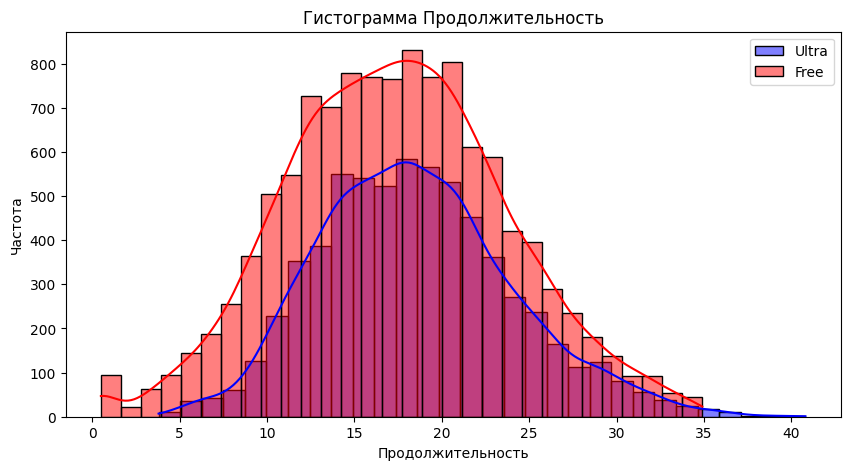

In [34]:
# Выбираем только нужные столбцы
columns_to_plot = ['distance', 'duration']
column_names = {'distance': 'Расстояние', 'duration': 'Продолжительность'}

# Построение гистограмм для пользователей с подпиской
for column in columns_to_plot:
    plt.figure(figsize=(10, 5))
    sns.histplot(data_ultra[column], bins=30, kde=True, color='blue', label='Ultra')
    sns.histplot(data_free[column], bins=30, kde=True, color='red', label='Free', alpha=0.5)
    plt.title(f'Гистограмма {column_names[column]}')
    plt.xlabel(column_names[column])
    plt.ylabel('Частота')
    plt.legend()
    plt.show()

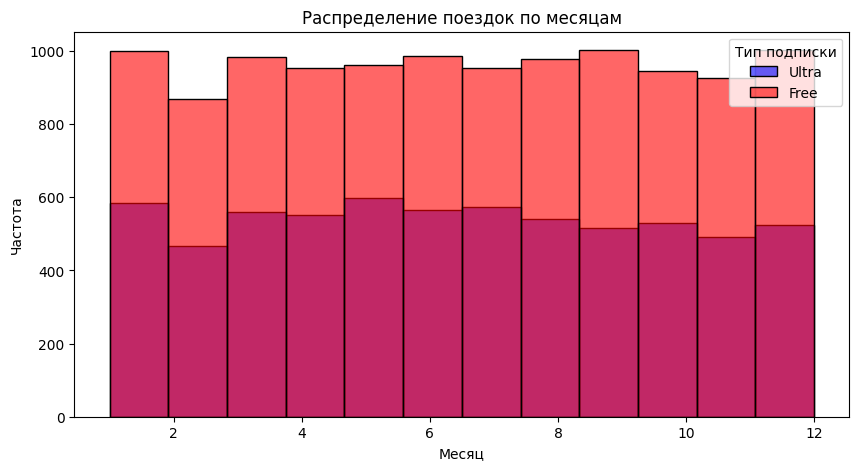

In [35]:
plt.figure(figsize=(10, 5))
sns.histplot(data_ultra['month'], bins=12, kde=False, color='blue', label='Ultra', alpha=0.6)
sns.histplot(data_free['month'], bins=12, kde=False, color='red', label='Free', alpha=0.6)
plt.title('Распределение поездок по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Частота')
plt.legend(title='Тип подписки')
plt.show()

<div style="border:solid green 2px; padding: 20px">
    
**Вывод**

Пользователи с подпиской составляют 37.3% от общего числа пользователей.

Возраст пользователей:
- распределен одинаково;
- и для подписки ulta, и для бесплатной подписки характерен возраст польззователей от 22 до 28 лет;
- срдеи пользователей старше 30 подписка ultra более популярна. 

Длительность поездки: 
- распределния близки к нормальному;
- характерна длительность от 15 до 22 минут.

Расстояние за одну поездку:
- пользователи с подпиской в среднем проезжают от 2.8 до 3.6 км;
- для пользователей без подпски характерна длительность от 2.6 до 4 км.

Месяц использования: 
- количесвто поездок во все месяца различается не сильно;
- среди пользователей с подпиской популряны июнь и август;
- пользователи без подписки набиолее часто используют сервис в январе;



# Подсчёт выручки
<a id='5'></a>

Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из прошлого блока: найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [36]:
agg_data = data.pivot_table(index = ['user_id', 'month', 'subscription_type'] , values = ['distance', 'duration'], aggfunc = ['sum', 'count'])
agg_data.columns = [ 'sum_distance', 'sum_duration', 'count', 'useless']
agg_data = agg_data.drop('useless', axis = 1)

agg_data.head(10)

sum_distance  sum_duration  count
user_id month subscription_type                                   
1       1     ultra                       7.0          41.4      2
        4     ultra                       0.8           6.2      1
        8     ultra                       6.7          44.8      2
        10    ultra                       5.8          31.6      2
        11    ultra                       6.9          53.3      3
        12    ultra                       6.7          27.2      2
2       3     ultra                      10.2          60.9      3
        4     ultra                       6.2          39.1      2
        6     ultra                       3.3          13.9      1
        7     ultra                       6.7          46.1      2

In [37]:
gr_data = data.groupby(['user_id', 'month','subscription_type']).agg({'duration': ['sum', 'count'], 'distance' : 'sum' }).reset_index()
gr_data.columns = ['user_id', 'month', 'subscription_type', 'sum_duration', 'count', 'sum_distance']
gr_data.head(10)

,user_id,month,subscription_type,sum_duration,count,sum_distance
0,1,1,ultra,41.4,2,7.0
1,1,4,ultra,6.2,1,0.8
2,1,8,ultra,44.8,2,6.7
3,1,10,ultra,31.6,2,5.8
4,1,11,ultra,53.3,3,6.9
5,1,12,ultra,27.2,2,6.7
6,2,3,ultra,60.9,3,10.2
7,2,4,ultra,39.1,2,6.2
8,2,6,ultra,13.9,1,3.3
9,2,7,ultra,46.1,2,6.7


В этот же датафрейм добавим столбец с помесячной выручкой, которую принёс каждый пользователь. Продолжительность каждой поездки в каждой строке исходного датафрейма для подсчёта стоимости округлим до следующего целого числа

In [38]:
gr_data['sum_duration'] = np.ceil(gr_data['sum_duration'])

def rev(row):
    revenue = 0
    if row['subscription_type'] == 'ultra': 
        revenue += subscr['subscription_fee'][1] + row['sum_duration']*subscr['minute_price'][1]        
    else:
        revenue += subscr['start_ride_price'][0]*row['count'] +  row['sum_duration']*subscr['minute_price'][0] 
    return revenue

gr_data['revenue'] = gr_data.apply(rev, axis =1)
gr_data.head()

,user_id,month,subscription_type,sum_duration,count,sum_distance,revenue
0,1,1,ultra,42.0,2,7.0,451.0
1,1,4,ultra,7.0,1,0.8,241.0
2,1,8,ultra,45.0,2,6.7,469.0
3,1,10,ultra,32.0,2,5.8,391.0
4,1,11,ultra,54.0,3,6.9,523.0


#  Проверка гипотез
<a id='6'></a>

Напишем общуюю функцию проверки гипотез:

In [39]:
def test_hyp(results, alpha):
    print('p-value =', results.pvalue)
    if results.pvalue < alpha:
        print('Отвергаем нулевую гипотезу')
    else:
        print('Не получилось отвергнуть нулевую гипотезу')

---

Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. 

Нулевая гипотеза: пользователи с подпиской тратят столько же времени на поездки, сколько и пользователи без подписки.

Альтернативная гипотеза: пользователи с подпиской тратят больше времени на поездки.

In [40]:
test_hyp(st.ttest_ind(data_ultra['duration'], data_free['duration'], alternative='greater'), 0.05)

p-value = 1.3448182372889e-34
Отвергаем нулевую гипотезу


Проверка с помощью t-теста показала, что стоит отвергнуть нулевую гипотезу в пользу альтенративной: то есть есть основания предполагать, что пользователи с подпиской тратят больше времени на поездки.

---

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

Нулевая гипотеза: пользователи с подпиской, в среднем, проезжают 3130 метров.

Альтернативная гипотеза: пользователи с подпиской проезжают больше 3130 метров.

In [41]:
popmean = 3.130

In [42]:
test_hyp(st.ttest_1samp(data_ultra['distance'], popmean, alternative = 'greater'), 0.05)

p-value = 0.9163021210579051
Не получилось отвергнуть нулевую гипотезу


Проверка с помощью t-теста показала, что на основании предоставленных данных нулевую гипотезу отвергнуть не получилось. Нет доказательств, что пользователи с подпиской проезжают не 3130 метров

---

Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Нулевая гипотеза: помесячная выручка от пользователей с подпиской равна помесчной выручке от пользоватлей без подписки 

Альтернативная гипотеза: помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки

In [43]:
test_hyp(st.ttest_ind(gr_data[gr_data['subscription_type']=='ultra']['revenue'], gr_data[gr_data['subscription_type']=='free']['revenue'], alternative='greater'), 0.05)

p-value = 1.8124385094177887e-35
Отвергаем нулевую гипотезу


Проверка с помощью t-теста показала, что стоит отвергнуть нулевую гипотезу в пользу альтенративной: то есть есть основания предполагать, что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

---

# Дополнительное исслеодование 
<a id='7'></a>

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 

Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясним, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. 

In [44]:
p = 0.1 #вероятность успеха (продление подписки)
N=1 #начальное значение количества промокодов. Потом будем увеличивать
x = 100 #минимально необходимое количество успехов
pr = 1 #вероятность получить x или меньше
while pr >= 0.05: #крутим цикл до тех пор пока вероятность получить x или меньше успехов будет меньше 5%
    mu = N*p
    sigma = (N*p*(1-p))**0.5
    x = 100
    distr = st.norm(mu, sigma) #приближаем биномиальное распредление нормальным
    pr = distr.cdf(x) # вероятность получить x или меньше
    N +=1

print(N)

1170



---

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации построим примерный график распределения и оценим вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

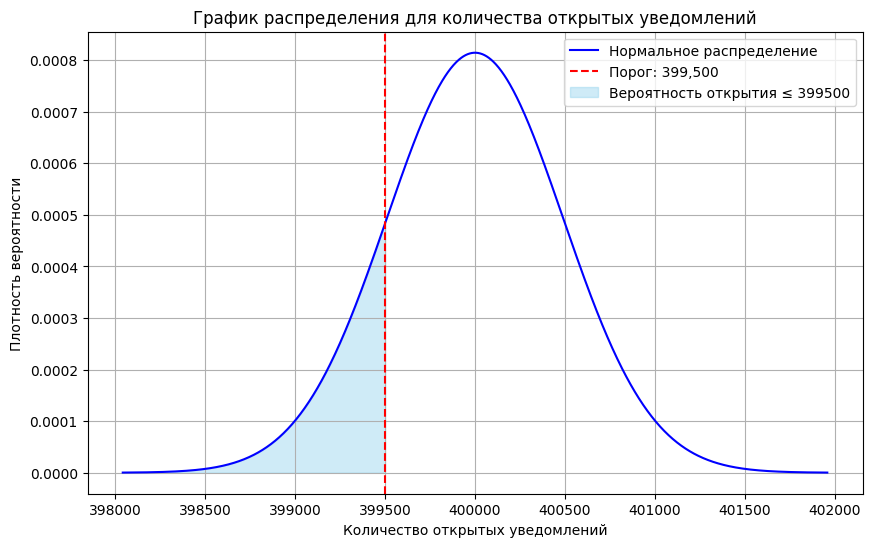

Вероятность того, что уведомление откроют не более 399,500 пользователей: 0.1537


In [45]:
# Параметры задачи
p = 0.4  # Вероятность того, что уведомление откроют
N = 1000000  # Количество отправленных уведомлений
x = 399500  # Максимальное количество открытий для оценки вероятности

# Параметры нормального распределения
mu = N * p  # Среднее
sigma = np.sqrt(N * p * (1 - p))  # Стандартное отклонение

# Создание диапазона значений для оси X
x_values = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
y_values = st.norm.pdf(x_values, mu, sigma)  # Вероятностная плотность нормального распределения

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, label='Нормальное распределение', color='b')
plt.fill_between(x_values, y_values, where=(x_values <= x), color='skyblue', alpha=0.4, label='Вероятность открытия ≤ 399500')

# Вероятность того, что уведомление откроют не более 399500 пользователей
pr = st.norm.cdf(x, mu, sigma)
plt.axvline(x=x, color='r', linestyle='--', label=f'Порог: {x:,}')
plt.xlabel('Количество открытых уведомлений')
plt.ylabel('Плотность вероятности')
plt.title('График распределения для количества открытых уведомлений')
plt.legend()
plt.grid(True)
plt.show()

# Вывод вероятности
print(f'Вероятность того, что уведомление откроют не более {x:,} пользователей: {pr:.4f}')

# Вывод
<a id='8'></a>

Была проведена предобработка данных: 
- выявлено, что данные предоставлены за 2021 год (с 1 января по 30 декабря)
- удалены явные дубликаты в таблице users;
- проверены данные на наличие пропусков и неявных дубликатов (таких не обнаружено);
- столбец 'date' приведен к типу date;
- столбец 'distance' переведен в км и округлен до 1 знака после запятой;
- столбец 'duration' округлен до 1 знака после запятой.

Исследовательский анализ данных был проведен с копиями исходных датафреймов. Его результаты: 
- все 8 городов встречаются почти одинаковое количестов раз, однако самый популярный город - Пятигорск (около 220 пользоватлей), а наименее популряный - Москва ( около 175 пользователей);
- пользовталей без подписки больше половины.

Далее данные таблиц users и rides были объеденены в одну таблицу data по стобцу 'user_id'. В методе merge по умолчанию стоял параметр объединения 'inner'.Таким образом, в объединенном датафрейме не могло появиться новых пропусков (с учетом того, что на этапе предобработки данных было выявлено, что пропусков в исходных таблицах нет). Более того, размерность объединенной таблицы совпала с размерностью таблицы good_rides. Также были созданы еще два датафрейма, которые будут хранить информацию о пользователях и поездках с подпиской и без.

Результаты исследования объединенных данных:
- Возраст пользователей:
    - распределен одинаково;
    - и для подписки ulta, и для бесплатной подписки характерен возраст польззователей от 22 до 28 лет;
    - срдеи пользователей старше 30 подписка ultra более популярна. 

- Длительность поездки: 
    - распредлена одинаково;
    - характерна длительность от 15 до 22 минут.

- Расстояние за одну поездку:
    - пользователи с подпиской в среднем проезжают от 2.8 до 3.6 км;
    - для пользователей без подпски характерна длительность от 2.6 до 4 км.

- Месяц использования: 
    - количесвто поездок во все месяца различается не сильно;
    - среди пользователей с подпиской популряны июнь и август;
    - пользователи без подписки набиолее часто используют сервис в январе;

Далее была рассчитана помесячная выручка, которую принес каждый пользователь. На основе этих данных была выдвинута гипотеза: помесячная выручка от пользователей с подпиской равна помесчной выручке от пользоватлей без подписки. Проверка с помощью t-теста показала, что стоит отвергнуть нулевую гипотезу в пользу альтенративной: то есть есть основания предполагать, что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Было проверено еще несколько гипотез: 
- тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Нулевая гипотеза отвергнута в пользу альтенративной: то есть есть основания предполагать, что пользователи с подпиской тратят больше времени на поездки.
- Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверка с помощью t-теста показала, что на основании предоставленных данных нулевую гипотезу отвергнуть не получилось. Нет доказательств, что пользователи с подпиской проезжают не 3130 метров.

Рекомендации по улучшению качества данных и направления дальнейших исследований:
- исследования показали, что пользователи с подпиской выгоднее для компании. Для увеличения числа подписок предлагается провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой существующие клиенты должны продлить эту подписку. Дополнительное исследование показало, что надо разослать 1170 промокодов, чтобы как минимум 100 пользователей продлили подписку;